In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa

%matplotlib inline
dataset_path = "../dataset/lfw_funneled/"

#### Showing sample of images checking to see if there are unusual image

In [190]:
from easyimages import EasyImageList
easy_list = EasyImageList.from_multilevel_folder(dataset_path)
easy_list

<ImageList with 13233 EasyImages [filter OFF]>

In [191]:
easy_list.html(sample=300, size=100, by_class=False)

In [192]:
# augmenter = iaa.Sequential([
#     iaa.Fliplr(0.5),  # horizontal flips
#     iaa.Affine(rotate=(-10, 10)),  # random rotations
#     iaa.GaussianBlur(sigma=(0, 1.0))  # random Gaussian blur
#  ])

In [3]:
people = []
features = []
images_aspect_ratios = []
for person in os.listdir(dataset_path):
    path = os.path.join(dataset_path,person)
    label = person
    imagesCount = os.listdir(path)
    #if the identity has over or 20 images
    if len(imagesCount) >=20:
        iteration_n = 0
        for img in os.listdir(path):
            iteration_n+=1
            if(iteration_n>=300):
                continue
            try:
                imgPath = os.path.join(path, img)
                person_img = cv2.imread(imgPath)
                person_img = person_img[30:, 30:]
                person_img = cv2.cvtColor(person_img, cv2.COLOR_RGB2GRAY)
                images_aspect_ratios.append(person_img.shape[1] / person_img.shape[0])
                people.append(person)
                features.append(person_img)
            except:
                continue

                
features = np.asarray(features)
people = np.asarray(people)

In [4]:
features.shape

(2792, 220, 220)

## Plotting images aspec ratios distribution

<AxesSubplot:ylabel='Count'>

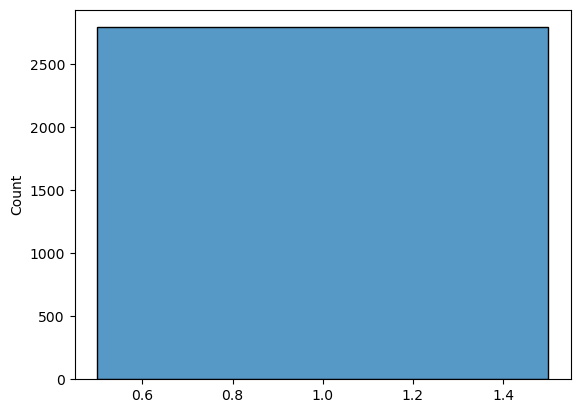

In [5]:
sns.histplot(data=images_aspect_ratios)

<font color='red'> UNIFORM DISTRIBUTION - All of the images have the same aspect ratios </font>

In [6]:
df = {'Target': people}
df = pd.DataFrame(df)
df.head()

Target
0  Jack_Straw
1  Jack_Straw
2  Jack_Straw
3  Jack_Straw
4  Jack_Straw

<function matplotlib.pyplot.show(close=None, block=None)>

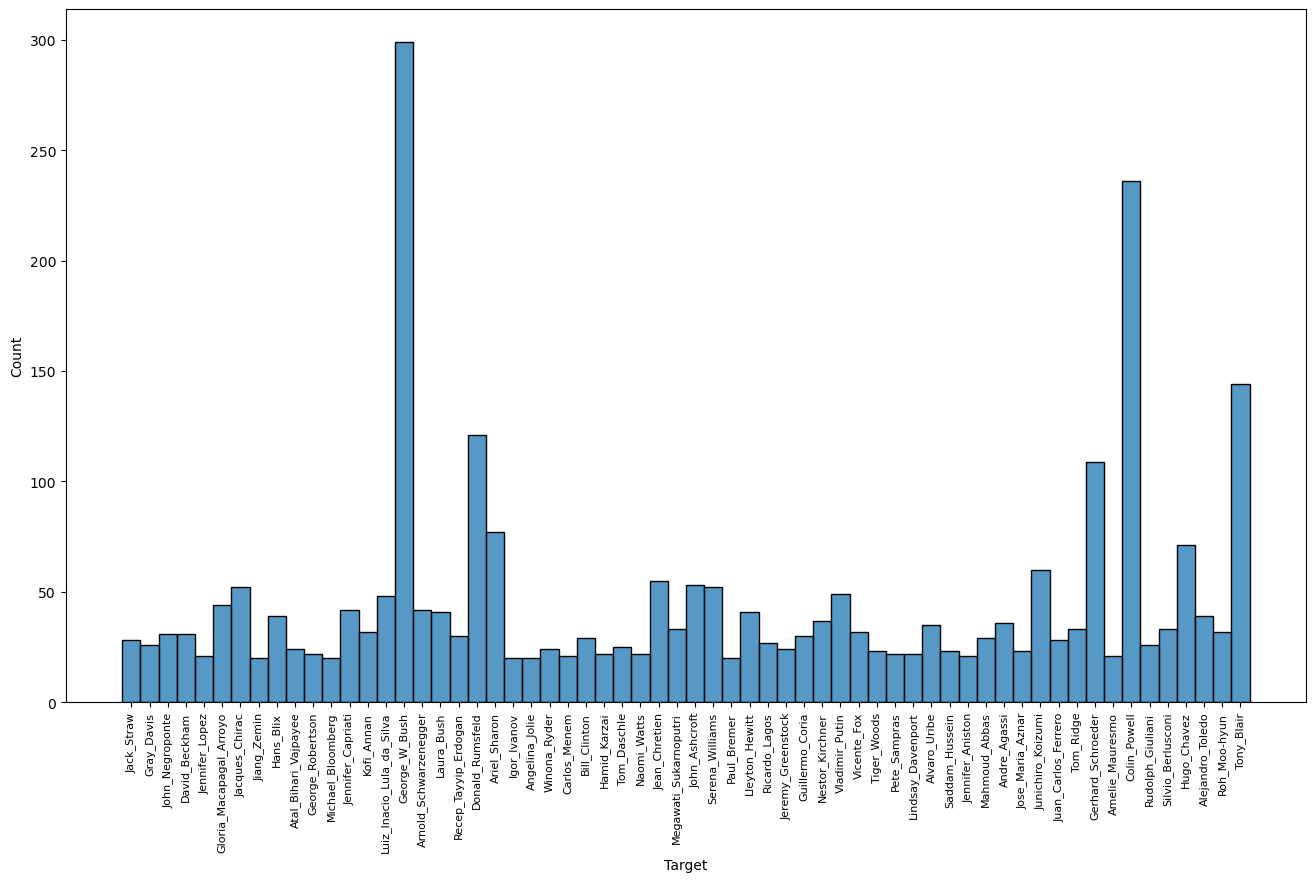

In [7]:
plt.figure(figsize=(16,9))
sns.histplot(df['Target'])
plt.xticks(rotation=90, fontsize=8)
plt.show

Cut frontal face and verify pixel histogram¶

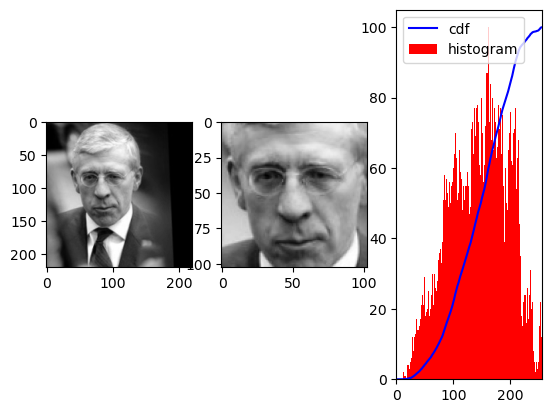

In [8]:
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

img = features[0]
faces = face_classifier.detectMultiScale(
    img,     
    scaleFactor=1.2,
    minNeighbors=5,     
    minSize=(20, 20)
)

for x,y,w,h in faces:
    img = img[y:y+h,x:x+w]
    
plt.subplot(1, 3, 1)
plt.imshow(features[0],cmap=plt.cm.gray)

plt.subplot(1, 3, 2)
plt.imshow(img, cmap = plt.cm.gray)

hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.subplot(1, 3, 3)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

### Apply filter and normalize pixel¶

In [9]:
listFace = []
for index in np.arange(len(features)):
    img = features[index]
    faces = face_classifier.detectMultiScale(
        img,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20)
    )

    for x,y,w,h in faces:
        img = img[y:y+h,x:x+w]
        
    if img.shape[1] > 0 and img.shape[0] > 0:
        img = cv2.resize(img, (60,60), interpolation = cv2.INTER_AREA)
#         img = cv2.resize(img, (40,40), interpolation = cv2.INTER_AREA)

        hist, bins = np.histogram(img.flatten(), 256, [0, 256])

        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max(),
        
        cdf_m = np.ma.masked_equal(cdf, 0)
        cdf_m = (cdf_m - cdf_m.min())*255 / (cdf_m.max()-cdf_m.min())
        cdf = np.ma.filled(cdf_m, 0).astype('uint8')

        img = cdf[img]
        #_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        listFace.append(img.reshape(60*60))
#         listFace.append(img.reshape(40*40))
    else:
        people[index] = float("NaN")

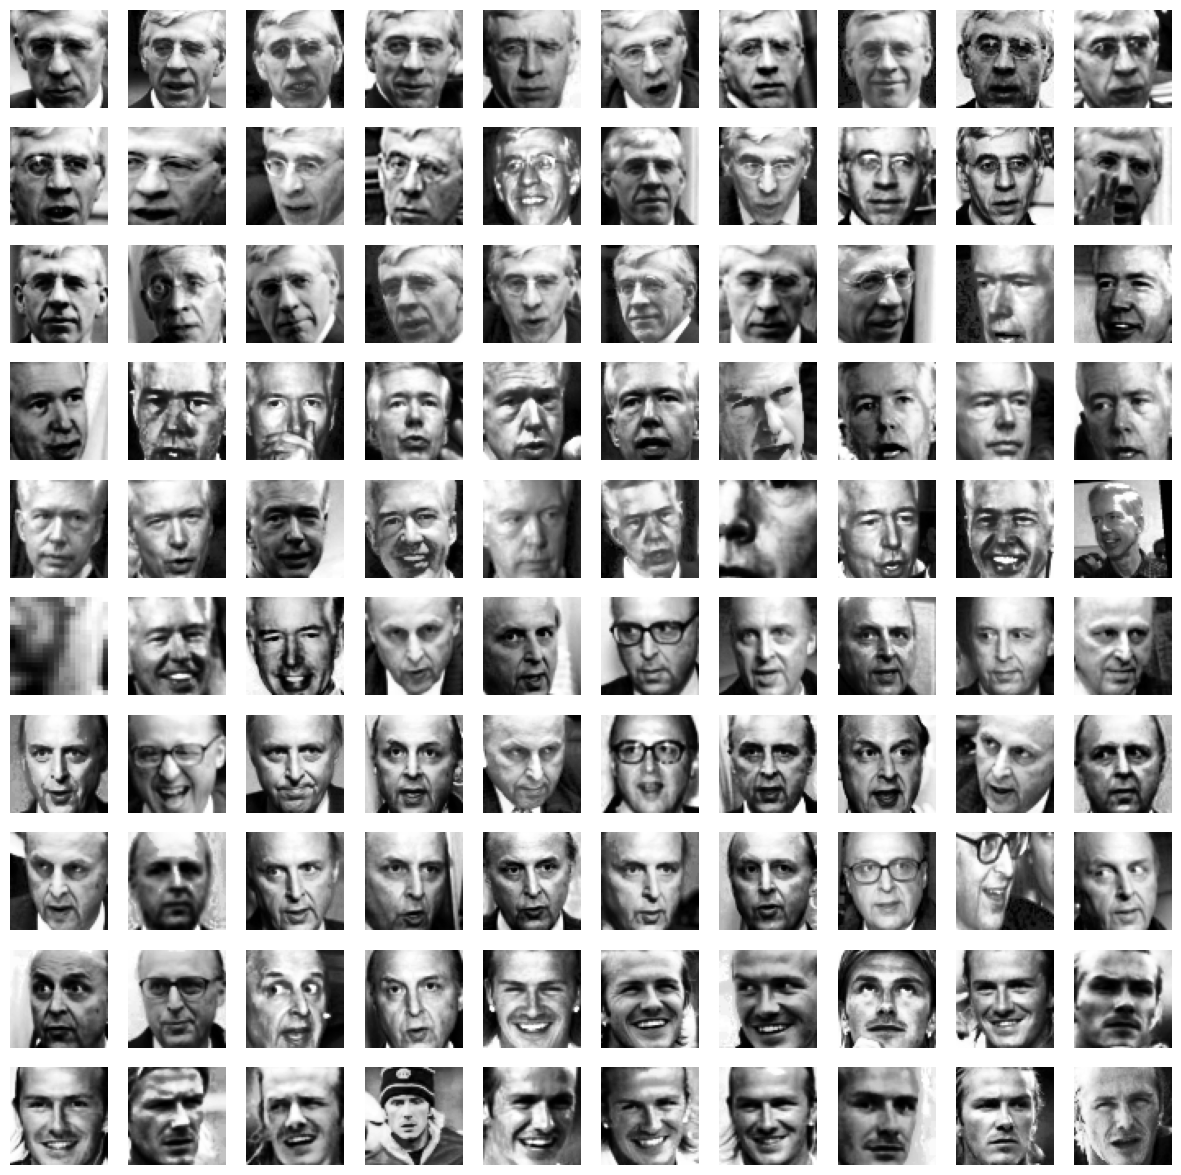

In [10]:
num_samples_to_display = 100

plt.figure(figsize=(15, 15))
for i in range(num_samples_to_display):
    plt.subplot(10, 10, i + 1)
    plt.imshow(listFace[i].reshape(60, 60), cmap='gray')
#     plt.imshow(listFace[i].reshape(40, 40), cmap='gray')
    plt.axis('off')

plt.show()

In [11]:
listFace = np.array(listFace)
listFace.shape

(2779, 3600)

In [12]:
print(len(listFace), len(people))

2779 2792


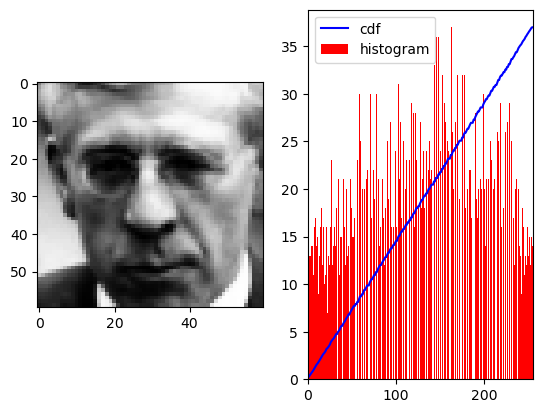

In [13]:
img = listFace[0].reshape(60,60)
# img = listFace[0].reshape(40,40)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap = plt.cm.gray)

hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.subplot(1, 2, 2)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


In [14]:
people = pd.DataFrame(people)

In [15]:
people.replace('nan', np.nan, inplace=True)
people.rename(columns={0: 'Target'}, inplace=True)

In [16]:
people.dropna(inplace = True)
people.reset_index(inplace = True, drop=True)

In [17]:
people['Target'].unique()

array(['Jack_Straw', 'Gray_Davis', 'John_Negroponte', 'David_Beckham',
       'Jennifer_Lopez', 'Gloria_Macapagal_Arroyo', 'Jacques_Chirac',
       'Jiang_Zemin', 'Hans_Blix', 'Atal_Bihari_Vajpayee',
       'George_Robertson', 'Michael_Bloomberg', 'Jennifer_Capriati',
       'Kofi_Annan', 'Luiz_Inacio_Lula_da_Silva', 'George_W_Bush',
       'Arnold_Schwarzenegger', 'Laura_Bush', 'Recep_Tayyip_Erdogan',
       'Donald_Rumsfeld', 'Ariel_Sharon', 'Igor_Ivanov', 'Angelina_Jolie',
       'Winona_Ryder', 'Carlos_Menem', 'Bill_Clinton', 'Hamid_Karzai',
       'Tom_Daschle', 'Naomi_Watts', 'Jean_Chretien',
       'Megawati_Sukarnoputri', 'John_Ashcroft', 'Serena_Williams',
       'Paul_Bremer', 'Lleyton_Hewitt', 'Ricardo_Lagos',
       'Jeremy_Greenstock', 'Guillermo_Coria', 'Nestor_Kirchner',
       'Vladimir_Putin', 'Vicente_Fox', 'Tiger_Woods', 'Pete_Sampras',
       'Lindsay_Davenport', 'Alvaro_Uribe', 'Saddam_Hussein',
       'Jennifer_Aniston', 'Mahmoud_Abbas', 'Andre_Agassi',
       'Jo

In [18]:
people.shape

(2779, 1)

In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(people['Target'])

In [22]:
print(len(listFace),len(y) )

2779 2779


In [23]:
X = pd.DataFrame(listFace)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y, random_state=42, stratify=y, test_size=0.2)

<function matplotlib.pyplot.show(close=None, block=None)>

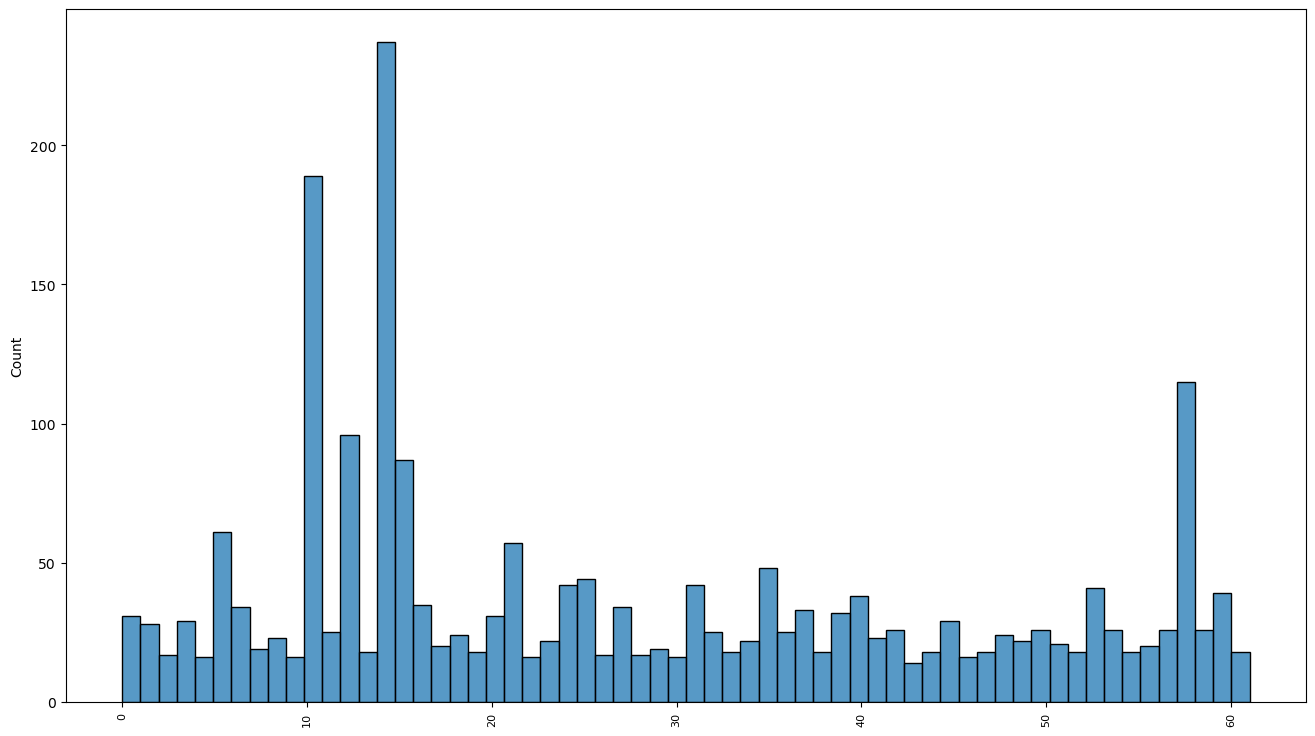

In [25]:
plt.figure(figsize=(16,9))
sns.histplot(y_train, bins=62)
plt.xticks(rotation=90, fontsize=8)
plt.show

In [26]:
h_flip_augmenter = iaa.Sequential([iaa.Fliplr(1)])  # Horizontal flips
zoom_augmenter = iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})
# rotate_augmenter = iaa.Affine(rotate=(-45, 45))  # Rotate the image by a random angle between -45 and 45 degrees

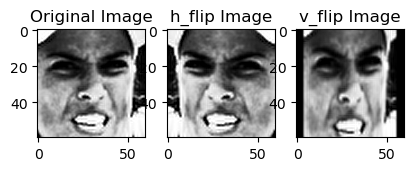

In [29]:
shape = (60,60)


h_flip_data = h_flip_augmenter.augment_image(X_train[2].reshape(shape))
h_flip_data = cv2.resize(h_flip_data, shape, interpolation=cv2.INTER_AREA)

zoom_flip_data = zoom_augmenter.augment_image(X_train[2].reshape(shape))
zoom_flip_data = cv2.resize(zoom_flip_data, shape, interpolation=cv2.INTER_AREA)

# rotate_data = rotate_augmenter.augment_image(X_train[2].reshape(40,40))
# rotate_data = cv2.resize(rotate_data, (40,40), interpolation=cv2.INTER_AREA)

plt.subplot(1, 4, 1)
plt.imshow(X_train[2].reshape(shape), cmap=plt.cm.gray, interpolation='sinc')
plt.title('Original Image')

    # Visualize augmented image mean
plt.subplot(1, 4, 2)
plt.imshow(h_flip_data, cmap=plt.cm.gray, interpolation='sinc')
plt.title('h_flip Image')

plt.subplot(1, 4, 3)
plt.imshow(zoom_flip_data, cmap=plt.cm.gray, interpolation='sinc')
plt.title('v_flip Image')

# plt.subplot(1, 4, 4)
# plt.imshow(rotate_data, cmap=plt.cm.gray, interpolation='sinc')
# plt.title('rotate image')


plt.show()    


In [30]:
y_train_df = pd.DataFrame({'target': y_train})
y_train_df.head()

target
0      60
1      30
2      12
3      58
4      53

In [31]:
augmented_images = []
augmented_labels = []
for index in range(0, len(X_train)):
    augmented_label = y_train[index]
    augment_counts = 1
#     if((y_train_df['target']==augmented_label).sum() > 100):
#         continue
    if (y_train_df['target']==augmented_label).sum() <50:
        augment_counts = 3
    elif (y_train_df['target']==augmented_label).sum() < 100:
        augment_counts = 2
        
    for _ in range(augment_counts):

        augmented_image = zoom_augmenter.augment_image(X_train[index].reshape(shape))
        augmented_image = cv2.resize(augmented_image, shape, interpolation=cv2.INTER_AREA)

        augmented_images.append(augmented_image)
        augmented_labels.append(augmented_label)


        augmented_image = h_flip_augmenter.augment_image(X_train[index].reshape(shape))
        augmented_image = cv2.resize(augmented_image, (shape), interpolation=cv2.INTER_AREA)

        augmented_images.append(augmented_image)
        augmented_labels.append(augmented_label)
        
X_train_augmented = np.asarray(augmented_images)
y_train_augmented = np.asarray(augmented_labels)

In [32]:
X_train_augmented = X_train_augmented.reshape((X_train_augmented.shape[0], -1))

In [33]:
print("Original labels:", y_train[:10])
print("Augmented labels:", y_train_augmented[:10])

Original labels: [60 30 12 58 53 38 31 32 39 60]
Augmented labels: [60 60 60 60 60 60 30 30 30 30]


In [34]:
print(X_train.shape, X_train_augmented.shape)

(2225, 3600) (10582, 3600)


In [35]:
X_train_combined = np.concatenate([X_train, X_train_augmented], axis=0)
# X_train_combined = X_train_augmented

In [36]:
# Repeat labels to match the size of the combined dataset
y_train_combined = np.concatenate([y_train, y_train_augmented], axis=0)
# y_train_combined = y_train_augmented

In [37]:
y_train_combined = y_train_combined.reshape(-1)
y_train_combined.shape

(12807,)

In [38]:
print(X_train_combined.shape, y_train_combined.shape)

(12807, 3600) (12807,)


<AxesSubplot:ylabel='Count'>

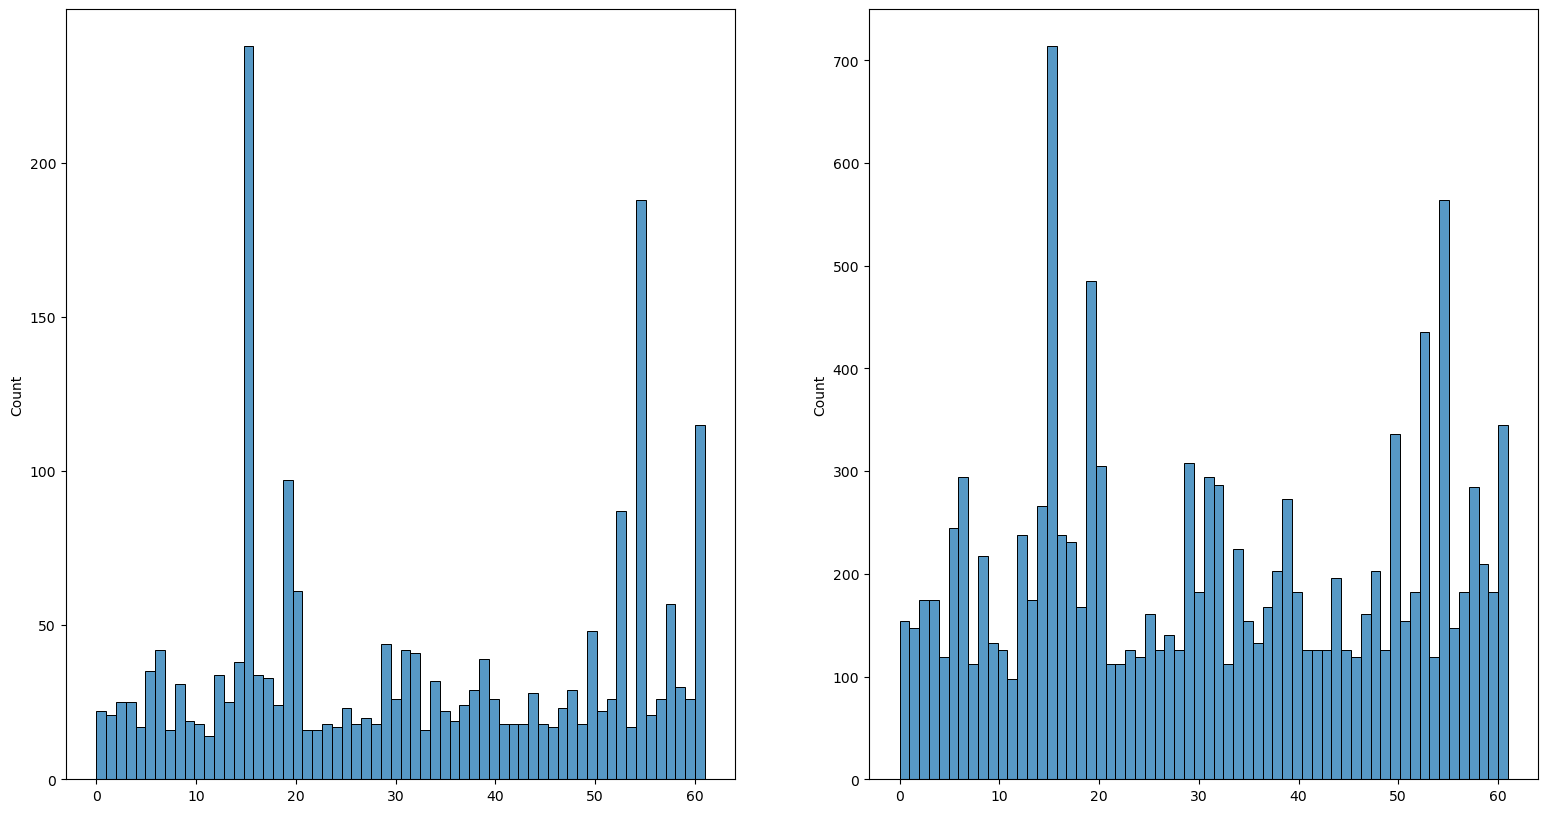

In [39]:
plt.figure(figsize=(19,10))
plt.subplot(1,2,1)
sns.histplot(y_train, bins=62)
plt.subplot(1,2,2)
sns.histplot(y_train_combined, bins=62)

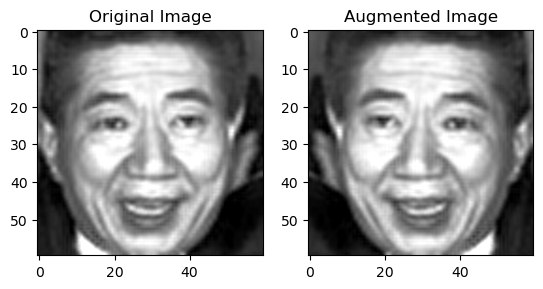

In [40]:
# Visualize original image mean
plt.subplot(1, 2, 1)
plt.imshow(X_train[0].reshape(shape), cmap=plt.cm.gray, interpolation='sinc')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(X_train_augmented[1].reshape(shape), cmap=plt.cm.gray, interpolation='sinc')
plt.title('Augmented Image')

plt.show()

In [44]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
images_scaled = scaler.fit_transform(X_train_combined)
# images_scaled = scaler.fit_transform(X_train)

In [45]:
from sklearn.decomposition import PCA
pca = PCA(0.98, copy=False)
pc_df = pca.fit_transform(images_scaled)

In [46]:
print(pc_df.shape)
sum(pca.explained_variance_ratio_) * 100

(12807, 591)


98.00001003392188

In [276]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis(n_components=5)
# X_train_lda = lda.fit_transform(images_scaled, y_train_combined)
# X_test_lda = lda.transform(X_test)

[CV 3/5] END ..............C=0.001, gamma=scale;, score=0.669 total time=  58.7s
[CV 5/5] END ..............C=0.001, gamma=scale;, score=0.643 total time=  59.0s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.701 total time=  52.4s
[CV 2/5] END ..................C=10, gamma=auto;, score=0.674 total time=  54.6s
[CV 5/5] END .................C=10, gamma=scale;, score=0.658 total time=  43.0s


Text(0.5, 1.0, 'Original Image')

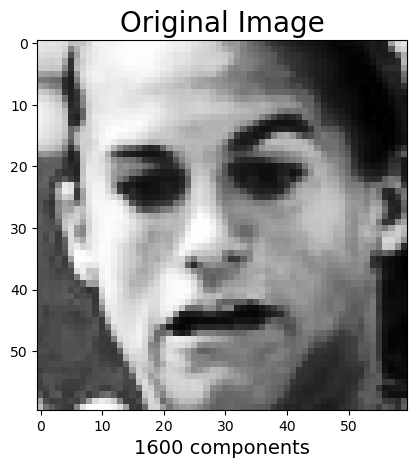

[CV 2/5] END ..............C=0.001, gamma=scale;, score=0.662 total time= 1.0min
[CV 5/5] END ................C=0.01, gamma=auto;, score=0.657 total time=  54.8s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.664 total time=  52.9s
[CV 1/5] END ..................C=10, gamma=auto;, score=0.690 total time=  54.0s
[CV 4/5] END .................C=10, gamma=scale;, score=0.701 total time=  44.4s
[CV 1/5] END ..............C=0.001, gamma=scale;, score=0.691 total time= 1.0min
[CV 1/5] END ...............C=0.01, gamma=scale;, score=0.692 total time=  53.3s
[CV 1/5] END ...................C=1, gamma=auto;, score=0.690 total time=  51.8s
[CV 5/5] END ..................C=1, gamma=scale;, score=0.658 total time=  54.1s
[CV 3/5] END .................C=10, gamma=scale;, score=0.664 total time=  46.9s


In [67]:
plt.imshow(X_train[0].reshape(shape),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255))
plt.xlabel(str(60*60) + ' components', fontsize = 14)
plt.title('Original Image', fontsize = 20)

In [47]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
param_grid = {'C': [0.001,0.01,1,10],  
              'gamma': [100,10,1,0.1], 
             }

grid = GridSearchCV(SVC(class_weight='balanced', kernel="linear"), param_grid, refit = True, verbose = 3,n_jobs=-1)
# grid = RandomizedSearchCV(SVC(class_weight='balanced', kernel='linear'), param_grid, refit = True, verbose = 3,n_jobs=-1)
grid.fit(pc_df, y_train_combined) 
# grid.fit(pc_df, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'C': 0.01, 'gamma': 100}


In [ ]:
print(grid.best_estimator_)

In [56]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', class_weight='balanced', gamma=100, C=0.01)
svc.fit(pc_df, y_train_combined)
# svc.fit(pc_df, y_train)

SVC(C=0.01, class_weight='balanced', gamma=100, kernel='linear')

In [57]:
scaler_test = scaler.transform(X_test)

In [58]:
pc_test = pca.transform(scaler_test)

In [59]:
prediction = svc.predict(pc_test)

In [60]:
from sklearn.metrics import accuracy_score

accuracy_score(prediction, y_test)

0.6714542190305206

In [54]:
print(X.shape, y.shape)

(2732, 1600) (2732,)


In [111]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc, X.values, y)

In [112]:
scores

array([0.62820513, 0.5970696 , 0.6007326 , 0.57326007, 0.62018349])

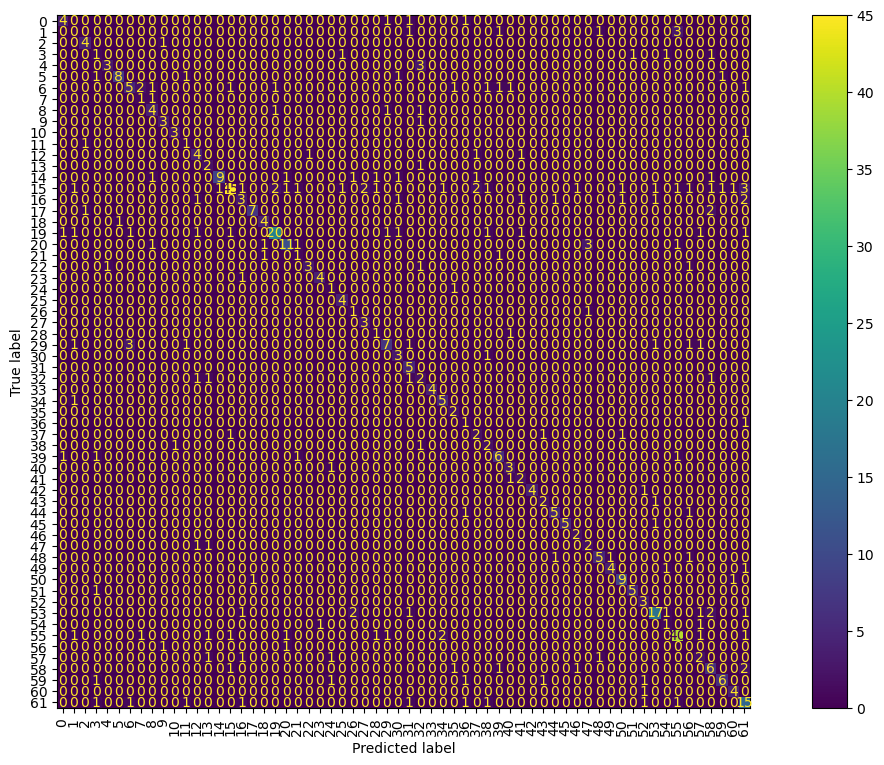

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
data = confusion_matrix(prediction, y_test)
data_display = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=svc.classes_)
fig, ax = plt.subplots(figsize=(16,9))
data_display.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction)) 

              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.00      0.00      0.00         5
           2       0.80      0.67      0.73         6
           3       0.20      0.17      0.18         6
           4       0.50      0.75      0.60         4
           5       0.67      0.89      0.76         9
           6       0.33      0.50      0.40        10
           7       0.50      0.25      0.33         4
           8       0.57      0.50      0.53         8
           9       0.75      0.60      0.67         5
          10       0.75      0.75      0.75         4
          11       0.50      0.25      0.33         4
          12       0.57      0.50      0.53         8
          13       0.67      0.33      0.44         6
          14       0.56      0.90      0.69        10
          15       0.63      0.90      0.74        50
          16       0.27      0.38      0.32         8
          17       0.70    